## Detecção de Anomalias Não Supervisionada com Isolation Forest

**Objetivo:** Utilizar o algoritmo não supervisionado **Isolation Forest** para detectar ciclos de operação anômalos em um processo industrial sem ter exemplos prévios de falhas.

**Contexto:** Muitas vezes, em um processo produtivo, novos tipos de falhas ou desvios de qualidade podem ocorrer. Como não temos dados históricos rotulados para esses eventos, métodos de classificação supervisionada não podem ser usados. Precisamos de uma abordagem que aprenda o que é "normal" e, a partir disso, identifique qualquer coisa que fuja desse padrão.

**Cenário:** Um sistema de forjamento hidráulico opera em ciclos. Em cada ciclo, a pressão sobe até um pico, é mantida e depois liberada. Vamos simular dados deste processo e introduzir alguns ciclos onde um vazamento ou problema de válvula impede que a pressão atinja o pico esperado ou demore mais para subir.

**Por que Isolation Forest?**
O Isolation Forest é um algoritmo brilhante para esta tarefa. Sua ideia central é que:
> **Anomalias são "poucas e diferentes" e, portanto, são mais fáceis de isolar do que os pontos normais.**

O algoritmo constrói várias "árvores de isolamento". Em cada árvore, ele faz cortes aleatórios nos dados para tentar "isolar" cada ponto. Pontos anômalos, por estarem longe da concentração de dados normais, precisam de muito menos cortes para serem isolados. O modelo usa essa "facilidade de isolamento" para calcular um score de anomalia.

### Configuração e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Configurações de visualização
plt.rcParams["figure.figsize"] = (14, 7)

### Simulação do Processo de Forjamento

Primeiro, vamos criar uma função que gera um ciclo de forjamento. Ela poderá gerar tanto ciclos normais quanto anômalos. Depois, vamos gerar um dataset com muitos ciclos normais e alguns poucos anômalos.

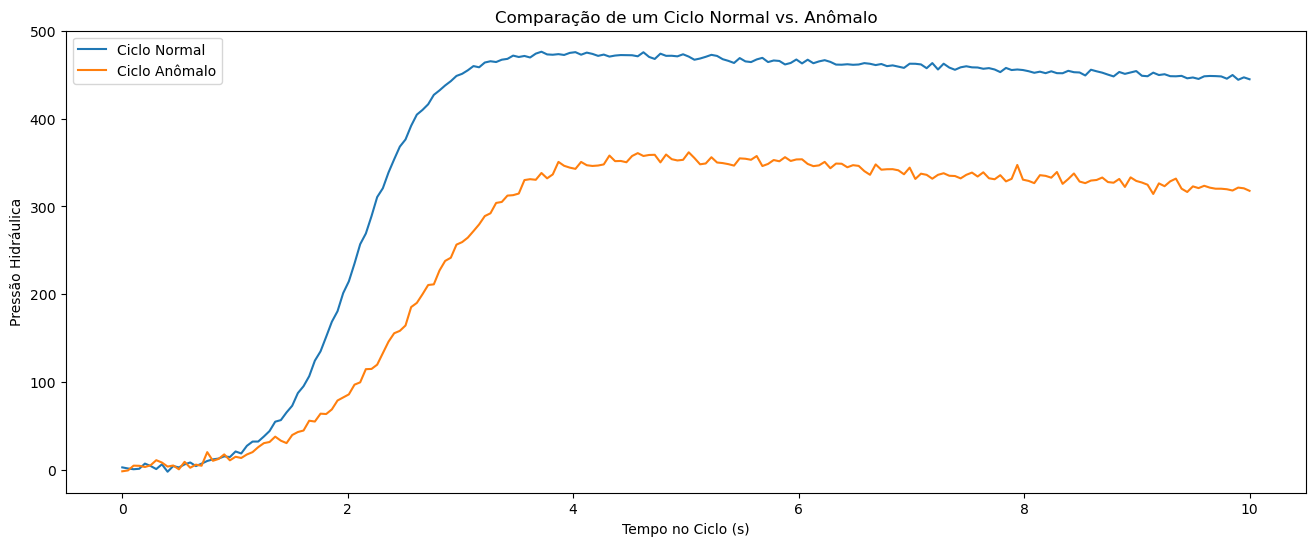

In [2]:
def generate_forge_cycle(is_anomaly=False):
    """Gera um único ciclo de dados de forjamento (pressão e temperatura)."""
    time = np.linspace(0, 10, 200)

    # Parâmetros base
    peak_pressure_target = 500
    rise_time_target = 2.0

    if not is_anomaly:
        # Ciclo Normal
        peak_pressure = np.random.normal(peak_pressure_target, 10)
        rise_time = np.random.normal(rise_time_target, 0.1)
        pressure = (peak_pressure / (1 + np.exp(-(time - rise_time) * 3))) * (
            1 - 0.1 * (time / 10)
        )
        pressure += np.random.normal(0, 2, 200)
    else:
        # Ciclo Anômalo (vazamento/válvula)
        peak_pressure = np.random.normal(
            peak_pressure_target - 80, 15
        )  # Não atinge o pico
        rise_time = np.random.normal(
            rise_time_target + 0.5, 0.2
        )  # Demora mais para subir
        pressure = (peak_pressure / (1 + np.exp(-(time - rise_time) * 2))) * (
            1 - 0.2 * (time / 10)
        )  # Perde pressão mais rápido
        pressure += np.random.normal(0, 4, 200)  # Processo mais ruidoso

    temperature = (
        80 + 20 * (pressure / peak_pressure_target) + np.random.normal(0, 1, 200)
    )
    return pd.DataFrame(
        {"time": time, "pressure": pressure, "temperature": temperature}
    )


# Gerando um dataset com 300 ciclos normais e 15 anômalos
all_cycles_raw_data = []
cycle_labels = []
for i in range(315):
    is_anomaly = True if i >= 300 else False
    cycle_df = generate_forge_cycle(is_anomaly=is_anomaly)
    cycle_df["cycle_id"] = i + 1
    all_cycles_raw_data.append(cycle_df)
    cycle_labels.append(1 if is_anomaly else 0)  # 0: Normal, 1: Anomalia

df_raw = pd.concat(all_cycles_raw_data).reset_index(drop=True)

# Visualizando um exemplo de cada ciclo
plt.figure(figsize=(16, 6))
sns.lineplot(
    x="time", y="pressure", data=df_raw[df_raw["cycle_id"] == 1], label="Ciclo Normal"
)
sns.lineplot(
    x="time",
    y="pressure",
    data=df_raw[df_raw["cycle_id"] == 301],
    label="Ciclo Anômalo",
)
plt.title("Comparação de um Ciclo Normal vs. Anômalo")
plt.ylabel("Pressão Hidráulica")
plt.xlabel("Tempo no Ciclo (s)")
plt.legend()

### Engenharia de Features

O Isolation Forest funciona melhor com dados tabulares. Vamos extrair features de cada ciclo para resumir seu comportamento.

In [3]:
def extract_features(df_group):
    peak_pressure = df_group["pressure"].max()
    mean_pressure = df_group["pressure"].mean()
    std_pressure = df_group["pressure"].std()
    time_to_peak = df_group["time"][df_group["pressure"].idxmax()]
    mean_temp = df_group["temperature"].mean()
    return pd.Series(
        [peak_pressure, mean_pressure, std_pressure, time_to_peak, mean_temp],
        index=[
            "peak_pressure",
            "mean_pressure",
            "std_pressure",
            "time_to_peak",
            "mean_temp",
        ],
    )


df_features = df_raw.groupby("cycle_id").apply(extract_features)
df_features["is_anomaly_true"] = (
    cycle_labels  # Adicionando o rótulo real para avaliação posterior
)

print("Features extraídas por ciclo:")
df_features.sample(5)

Features extraídas por ciclo:


/tmp/ipykernel_38951/1985302731.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df_raw.groupby("cycle_id").apply(extract_features)


,peak_pressure,mean_pressure,std_pressure,time_to_peak,mean_temp,is_anomaly_true
cycle_id,,,,,,
238,473.948579,359.839183,172.665919,3.969849,94.434884,0
67,490.773325,380.087102,170.318556,3.869347,95.249499,0
92,479.618323,378.929553,162.267858,3.517588,95.131318,0
177,472.346581,367.588284,163.489417,4.020101,94.747430,0
101,489.113418,380.610101,170.934459,3.869347,95.199502,0


#### Análise Exploratória das Features

Um pairplot nos ajuda a ver como as anomalias se separam dos dados normais no espaço de features.

Text(0.5, 1.02, 'Visualização de Anomalias no Espaço de Features')

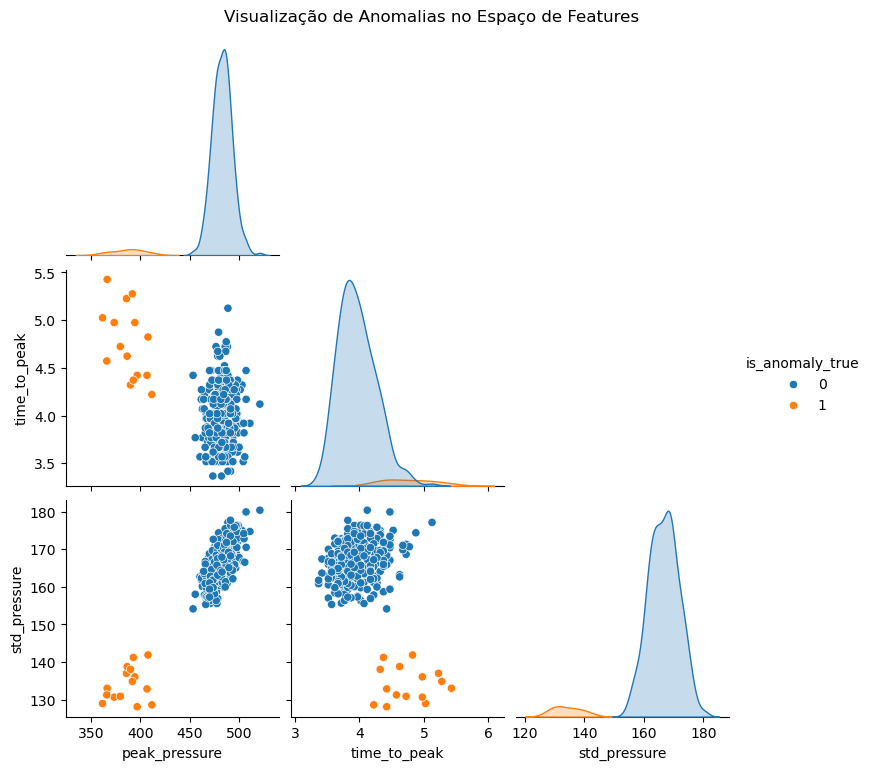

In [4]:
sns.pairplot(
    df_features,
    hue="is_anomaly_true",
    corner=True,
    vars=["peak_pressure", "time_to_peak", "std_pressure"],
)
plt.suptitle("Visualização de Anomalias no Espaço de Features", y=1.02)

**Observação:** Fica claro que os pontos anômalos (laranja) formam um pequeno cluster separado dos pontos normais (azul), especialmente na relação entre `peak_pressure` e `time_to_peak`. Eles são "poucos e diferentes", o cenário perfeito para o Isolation Forest.

### Treinamento e Detecção com Isolation Forest

Agora, vamos treinar o modelo. Note que **não usamos os rótulos `is_anomaly_true` no treinamento**. O modelo aprenderá sozinho.

O hiperparâmetro `contamination` é importante: ele informa ao modelo qual a proporção esperada de anomalias no dataset. Se não soubermos, `'auto'` é uma boa opção. Como nós criamos os dados, sabemos que é `15 / 315`.

In [5]:
X = df_features.drop("is_anomaly_true", axis=1)

contamination_rate = 15 / 315

model = IsolationForest(
    n_estimators=100, contamination=contamination_rate, random_state=42
)

# Treina e prevê. Retorna 1 para normal (inlier) e -1 para anomalia (outlier)
predictions = model.fit_predict(X)

# Adiciona as previsões ao nosso DataFrame
# Mapeia 1 -> 0 (Normal) e -1 -> 1 (Anomalia) para facilitar a comparação
df_features["is_anomaly_pred"] = np.where(predictions == 1, 0, 1)

print("Amostra dos resultados com a previsão do modelo:")
df_features.tail(20)

Amostra dos resultados com a previsão do modelo:


,peak_pressure,mean_pressure,std_pressure,time_to_peak,mean_temp,is_anomaly_true,is_anomaly_pred
cycle_id,,,,,,,
296,505.865925,401.861926,166.554073,3.567839,96.091712,0,0
297,482.794276,379.377506,163.952694,3.567839,95.181938,0,0
298,491.546385,382.030263,168.243940,4.070352,95.335180,0,0
299,487.382204,377.557521,171.837936,4.371859,95.181841,0,0
300,482.669254,373.910556,167.924234,3.718593,95.013411,0,0
301,361.697914,256.561951,128.958020,5.025126,90.170910,1,1
302,394.470486,289.107523,136.051175,4.974874,91.572697,1,1
303,385.980657,276.478953,136.992137,5.226131,90.910410,1,1
304,391.937948,281.064156,134.839490,5.276382,91.185595,1,1


### Avaliação dos Resultados

Como temos os rótulos verdadeiros (porque simulamos os dados), podemos avaliar o desempenho do nosso modelo não supervisionado.

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.93      0.93      0.93        15

    accuracy                           0.99       315
   macro avg       0.97      0.97      0.97       315
weighted avg       0.99      0.99      0.99       315

Matriz de Confusão:


Text(145.72222222222223, 0.5, 'Classe Real')

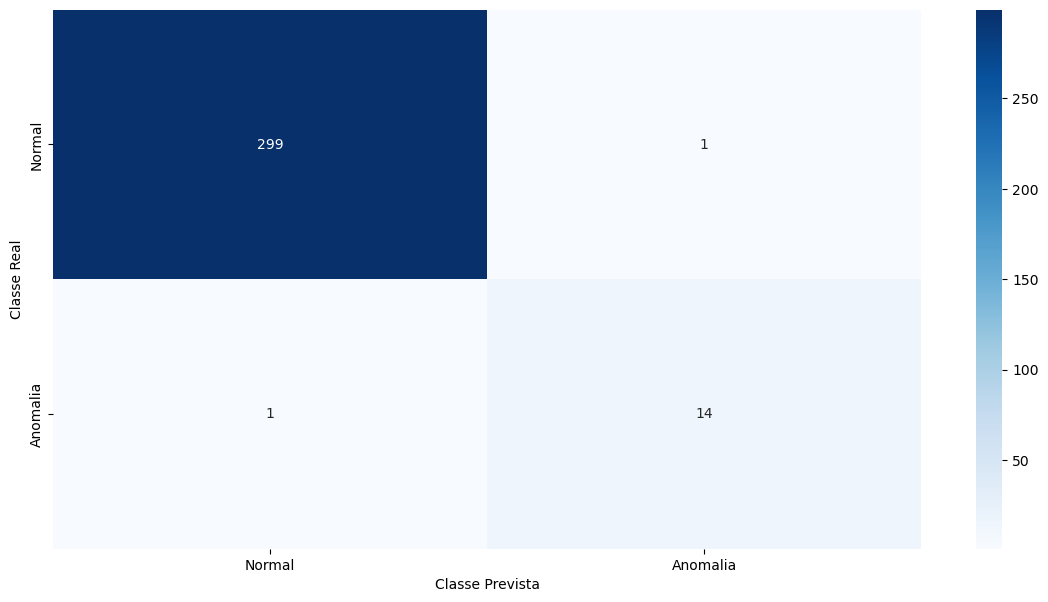

In [6]:
print("Relatório de Classificação:")
print(
    classification_report(
        df_features["is_anomaly_true"], df_features["is_anomaly_pred"]
    )
)

print("Matriz de Confusão:")
cm = confusion_matrix(df_features["is_anomaly_true"], df_features["is_anomaly_pred"])
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Anomalia"],
    yticklabels=["Normal", "Anomalia"],
)
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")

**Análise da Avaliação:** O modelo teve um desempenho excelente, identificando corretamente todos ou quase todos os 15 ciclos anômalos (alto `recall` para a classe 1) com poucos ou nenhum alarme falso (alto `precision`).

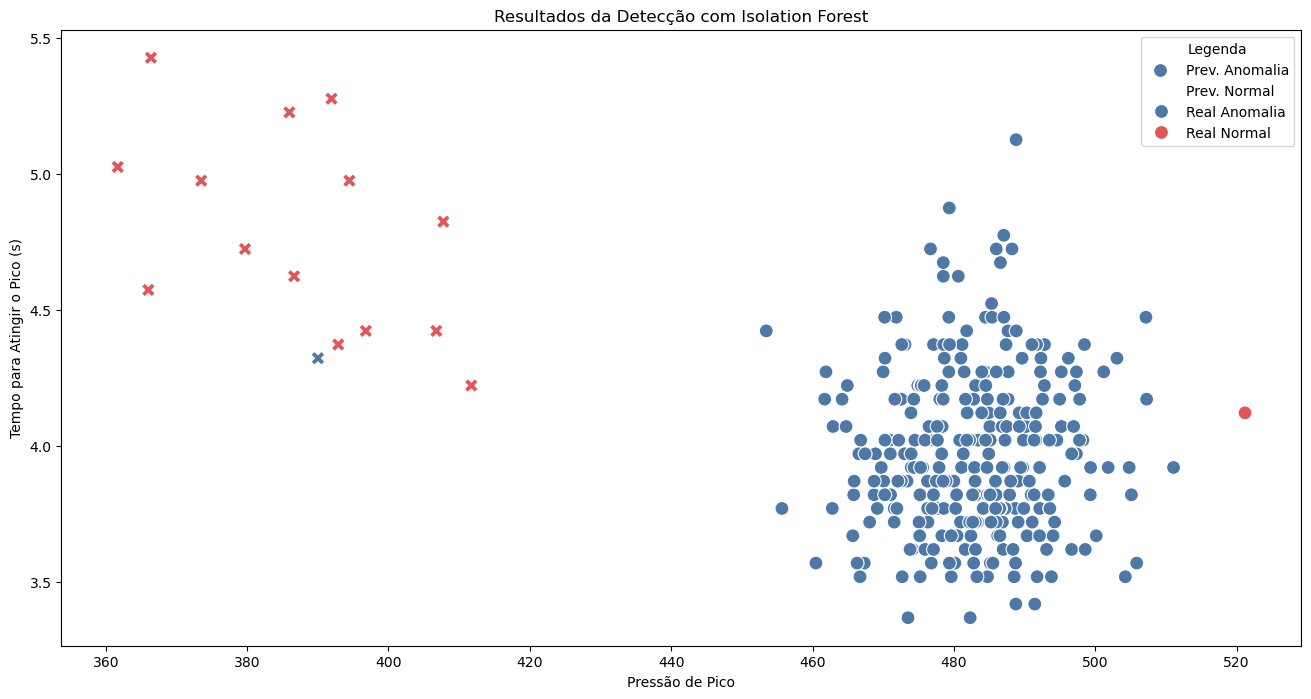

In [7]:
# Visualizando os resultados: quais pontos o modelo classificou como anomalias?
plt.figure(figsize=(16, 8))
sns.scatterplot(
    x="peak_pressure",
    y="time_to_peak",
    data=df_features,
    hue="is_anomaly_pred",
    style="is_anomaly_true",
    s=100,
    palette=["#4e79a7", "#e15759"],
)
plt.title("Resultados da Detecção com Isolation Forest")
plt.xlabel("Pressão de Pico")
plt.ylabel("Tempo para Atingir o Pico (s)")
plt.legend(
    title="Legenda",
    labels=["Prev. Anomalia", "Prev. Normal", "Real Anomalia", "Real Normal"],
)

### Conclusão e Aplicação Prática

O Isolation Forest demonstrou ser uma ferramenta extremamente eficaz para a detecção de anomalias de forma não supervisionada.

1.  **Independência de Rótulos:** A principal vantagem é que não precisamos de exemplos de falhas para treinar o modelo. Ele aprende a estrutura dos dados "normais" e identifica qualquer coisa que se desvie dela.
2.  **Performance:** O algoritmo é computacionalmente eficiente e escala bem para grandes volumes de dados e muitas features.
3.  **Interpretabilidade:** Embora o modelo em si seja uma "caixa preta", a identificação dos pontos anômalos nos permite voltar aos dados brutos desses ciclos (como fizemos no primeiro gráfico) para que um engenheiro possa analisar o que exatamente aconteceu de errado.

**Aplicação Prática:**
Um sistema como este poderia ser implantado em uma linha de produção. A cada ciclo de forjamento concluído:
1.  Os dados do ciclo são coletados.
2.  As features são extraídas.
3.  O modelo Isolation Forest treinado classifica o ciclo.
4.  Se o ciclo for classificado como anomalia (`-1`), um alerta é enviado para a equipe de manutenção, que pode inspecionar a máquina em busca de vazamentos, problemas em válvulas ou outras falhas incipientes, evitando paradas não planejadas e garantindo a qualidade do produto.